In [6]:
import datetime
ts1=datetime.datetime.now().timestamp()
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import pathlib 
"""
User must imput CoordNo which indicates which location to forecast and VarNo to chose among Temperature, GHI and Wind Speed 
"""
print("Imports done")

# from pyramid.arima import auto_arima

#Columns= Year  Month  Day  Hour  Minute  GHI  Wind Speed  Temperature  Latitude  Longitude Coords datetime

Imports done


In [50]:

data_path="/home/bleon/Documents/DS4A/DS4A_Project/Processed_Data/"

#Data import and grouping
CompleteDF=pd.read_csv(data_path+"MeteorCOLUnited.csv",usecols=["Year","Month","Day","Hour","Minute","Wind Speed","GHI","Temperature","Latitude","Longitude"])
CompleteDF["datetime"]=pd.to_datetime(CompleteDF["Year"].astype("str")+"-"+CompleteDF["Month"].astype("str")+"-"+CompleteDF["Day"].astype("str")+" "+CompleteDF["Hour"].astype("str")+":"+CompleteDF["Minute"].astype("str")+":00")
CompleteDF["Coords"]=list(zip(CompleteDF["Latitude"],CompleteDF["Longitude"]))
#Cleaning inputs
print("Data done")
#Columns= Year  Month  Day  Hour  Minute  GHI  Wind Speed  Temperature  Latitude  Longitude Coords datetime



Data done


In [114]:
#Inputs
Variables_to_forecast=["Temperature","GHI","Wind Speed"]
AllCoords=CompleteDF["Coords"].unique().tolist()
VarNo=0
CoordNo=2
Variable=Variables_to_forecast[VarNo]
Location=AllCoords[CoordNo]

#Testing on first latitude
print("Location chosen - coordinates= {}".format(Location))
print("Variable to forecast: {}".format(Variable))

Location chosen - coordinates= (9.73, -73.86)
Variable to forecast: Temperature


To forecast monthly data we will take monthly data for every variable for a station untill 2019 and forecast 2020 as testing data

In [115]:
DF=CompleteDF[CompleteDF["Coords"]==Location][["Year","Month","Coords",Variable,"datetime"]].groupby(["Year","Month","Coords"]).mean().reset_index()
DF["datetime"]=pd.to_datetime(DF["Year"].astype("str")+"-"+DF["Month"].astype("str")+"-01")
DF.head(5)

,Year,Month,Coords,Temperature,datetime
0,1999,1,"(9.73, -73.86)",28.052419,1999-01-01
1,1999,2,"(9.73, -73.86)",28.196429,1999-02-01
2,1999,3,"(9.73, -73.86)",29.816532,1999-03-01
3,1999,4,"(9.73, -73.86)",28.833333,1999-04-01
4,1999,5,"(9.73, -73.86)",27.336022,1999-05-01


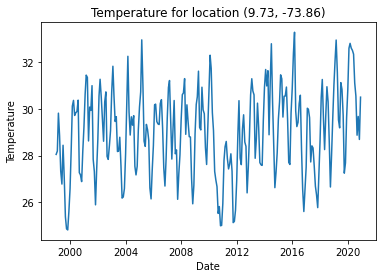

In [116]:
fig=plt.figure(figsize=(12,5))
# DF[[Variable,"datetime"]][Variable].plot()
plt.plot( DF[[Variable,"datetime"]]["datetime"], DF[[Variable,"datetime"]][Variable])
plt.xlabel("Date")
plt.ylabel(Variable)
plt.title(Variable+" for location "+str(Location))
plt.show()

In [117]:
#Testing with data from all years before
Train=DF[DF["Year"]<2020][Variable]
Train_dates=DF[DF["Year"]<2020]["datetime"]
Test=DF[DF["Year"]==2020][Variable]
Test_dates=DF[DF["Year"]==2020]["datetime"]

In [144]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
P=1
D=2
Q=1
S=12
model=ARIMA(Train,seasonal_order=(P,D,Q,S)).fit()
print(model.aic)

880.7245124354532


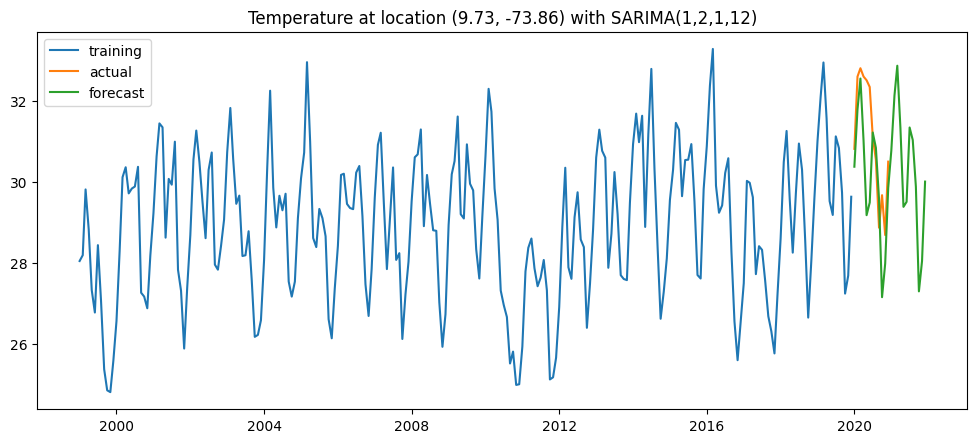

In [143]:
fc = model.forecast(24, alpha=0.05)
fc_series = pd.Series(fc)
fc_dates=pd.to_datetime(pd.Series(["2020-"+str(i+1)+"-01" for i in range(12)]+["2021-"+str(i+1)+"-01" for i in range(12)]))
# fc_series = pd.Series(fc, index=Test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.title(Variable+" at location {} with SARIMA({},{},{},{})".format(Location,P,D,Q,S))
plt.plot(Train_dates,Train, label='training')
plt.plot(Test_dates,Test, label='actual')
plt.plot(fc_dates,fc_series, label='forecast')
plt.legend()
plt.show()

In [ ]:
def ArimaForecast(loca,vari,ARp=1,Id=2,MAq=1,SEs=12):
    NewDF=CompleteDF[CompleteDF["Coords"]==loca][["Year","Month","Coords",vari,"datetime"]].groupby(["Year","Month","Coords"]).mean().reset_index()
    NewDF["datetime"]=pd.to_datetime(NewDF["Year"].astype("str")+"-"+NewDF["Month"].astype("str")+"-01")
    TimeSeries=NewDF[vari]
    TimeSeries_dates=NewDF["datetime"]
    TheModel_fitted=ARIMA(TimeSeries,seasonal_order=(ARp,Id,MAq,SEs))
    
    NewForecast=pd.Series(TheModel_fitted.forecast(24, alpha=0.05)).tolist()
    NewForecast_dates=pd.to_datetime(pd.Series(["2020-"+str(i+1)+"-01" for i in range(12)]+["2021-"+str(i+1)+"-01" for i in range(12)])).tolist()
    
    MyForecast={"Location":loca,"Variable":vari,"Values":NewForecast,"datetime":NewForecast_dates,"AIC":TheModel_fitted.aic}
    MyData={"Location":loca,"Variable":vari,"Values":TimeSeries,"datetime":TimeSeries_dates}
    return MyData,MyForecast